In [1]:
import re
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

Импортируем датасет с kaggle


In [2]:
data = pd.read_csv("/kaggle/input/lang-data/rus.txt", delimiter='\t', header=None)

Переименуем колонки и перераспределим их

In [3]:
data.rename(columns={0: 'en', 1: 'ru', 2: 'comment'}, inplace=True)
data = data[['en', 'ru']]
data

,en,ru
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
...,...,...
363381,"In today's world, we have to equip all our kid...",В современном мире перед нами стоит задача дат...
363382,Death is something that we're often discourage...,"Смерть - это зачастую то, разговоры или даже м..."
363383,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш..."
363384,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,..."


Отчистим текст от лишних символов, дублирующихся пробелов и приведем к нижнему регистру

In [4]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [5]:
data['en'] = data['en'].apply(clean_text)
data['ru'] = data['ru'].apply(clean_text)
data

,en,ru
0,go,марш
1,go,иди
2,go,идите
3,hi,здравствуйте
4,hi,привет
...,...,...
363381,in today s world we have to equip all our kids...,в современном мире перед нами стоит задача дат...
363382,death is something that we re often discourage...,смерть это зачастую то разговоры или даже мысл...
363383,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...
363384,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...


Функция создания словаря токенов

In [6]:
def build_vocab(sentences, special_tokens=None):
    if special_tokens is None:
        special_tokens = ['<PAD>', '<SOS>', '<EOS>']

    token_to_id = {token: idx for idx, token in enumerate(special_tokens)}
    id_to_token = {idx: token for idx, token in enumerate(special_tokens)}

    unique_tokens = set()
    for sentence in sentences:
        unique_tokens.update(sentence.split())

    for token in unique_tokens:
        if token not in token_to_id:
            idx = len(token_to_id)
            token_to_id[token] = idx
            id_to_token[idx] = token

    return token_to_id, id_to_token

Построим словари

In [7]:
source_vocab, _ = build_vocab(data['en'])
target_vocab, _ = build_vocab(data['ru'])

In [8]:
def tokenize_and_encode(sentence, vocab):
    sentence_tokens = ['<SOS>'] + sentence.split(' ') + ['<EOS>']
    return [vocab[token] for token in sentence_tokens]

In [9]:
encoded_source = [tokenize_and_encode(sentence, source_vocab) for sentence in data['en']]
encoded_target = [tokenize_and_encode(sentence, target_vocab) for sentence in data['ru']]

Разделяем датасет 

In [10]:
def split_dataset(source_sentences, target_sentences, train_ratio=0.8, val_ratio=0.1):
    train_src, temp_src, train_tgt, temp_tgt = train_test_split(
        source_sentences, target_sentences, test_size=(1 - train_ratio), random_state=42
    )
    val_ratio_adjusted = val_ratio / (1 - train_ratio)
    val_src, test_src, val_tgt, test_tgt = train_test_split(
        temp_src, temp_tgt, test_size=(1 - val_ratio_adjusted), random_state=42
    )
    return (train_src, train_tgt), (val_src, val_tgt), (test_src, test_tgt)

In [11]:
(train_src, train_tgt), (val_src, val_tgt), (test_src, test_tgt) = split_dataset(encoded_source, encoded_target)

In [12]:
class MyDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data
        assert len(self.src_data) == len(self.tgt_data)

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, index):
        src_item = self.src_data[index]
        tgt_item = self.tgt_data[index]
        return src_item, tgt_item

In [13]:
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_pad_idx, tgt_pad_idx = 0, 0
    src_batch_tensor = pad_sequence([torch.tensor(src) for src in src_batch], padding_value=src_pad_idx, batch_first=True)
    tgt_batch_tensor = pad_sequence([torch.tensor(tgt) for tgt in tgt_batch], padding_value=tgt_pad_idx, batch_first=True)
    return src_batch_tensor, tgt_batch_tensor

Берем отрезок из датасетов наших данных т.к. нет мощностей для обучения всего датасета

In [14]:
train_dataset = MyDataset(train_src[100000:250001], train_tgt[100000:250001])
val_dataset = MyDataset(val_src[10000:25001], val_tgt[10000:25001])

Создаем даталоадеры для последующего обучения модели

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2)

Реализация seq2seq модели черезе LSTM

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, n_layers, dropout, device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, (hidden, cell)

In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, n_layers, dropout, device):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, cell):
        input_token = input_token.unsqueeze(1)
        embedded = self.dropout(self.embedding(input_token))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.device = device
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        tgt_len = tgt.shape[1]
        batch_size = tgt.shape[0]
        tgt_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        encoder_outputs, (hidden, cell) = self.encoder(src)

        input_token = tgt[:, 0]
        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            input_token = tgt[:, t] if random.random() < teacher_forcing_ratio else top1
        return outputs

Функция обучения модели

In [19]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    progress = tqdm(iterator, total=len(iterator), desc="Training", leave=False)
    for src, tgt in progress:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)
        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        progress.set_postfix(loss=loss.item())
    return epoch_loss / len(iterator)


Функция eval для валидационной выборки модели

In [20]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    progress = tqdm(iterator, total=len(iterator), desc="Evaluating", leave=False)
    with torch.no_grad():
        for src, tgt in progress:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
            progress.set_postfix(loss=loss.item())
    return epoch_loss / len(iterator)

Инициализируем модель 

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = len(source_vocab)
OUTPUT_DIM = len(target_vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
N_LAYERS = 2
DROPOUT = 0.5
CLIP = 1.0
N_EPOCHS = 10
BATCH_SIZE = 32

encoder = Encoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT, device)
decoder = Decoder(OUTPUT_DIM, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT, device)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

Обучение модели

In [22]:
train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    val_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch: {epoch + 1:02} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}")


Epoch: 01 | Train Loss: 5.166 | Val Loss: 4.506


Epoch: 02 | Train Loss: 4.039 | Val Loss: 3.971


Epoch: 03 | Train Loss: 3.489 | Val Loss: 3.674


Epoch: 04 | Train Loss: 3.106 | Val Loss: 3.497


Epoch: 05 | Train Loss: 2.825 | Val Loss: 3.353


Epoch: 06 | Train Loss: 2.606 | Val Loss: 3.267


Epoch: 07 | Train Loss: 2.429 | Val Loss: 3.204


Epoch: 08 | Train Loss: 2.284 | Val Loss: 3.128


Epoch: 09 | Train Loss: 2.164 | Val Loss: 3.084


Epoch: 10 | Train Loss: 2.057 | Val Loss: 3.047


График кросс-энтропии для train и val

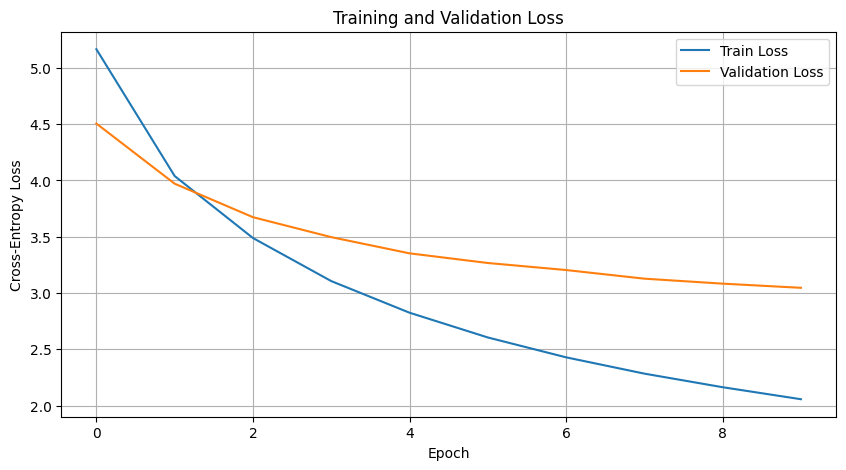

In [24]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
!pip install nltk

In [26]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [ ]:
Функция вычисления bleu

In [30]:
def compute_bleu(model, iterator, target_vocab):
    model.eval()
    total_bleu = 0
    n_sentences = 0

    with torch.no_grad():
        progress = tqdm(iterator, desc="Calculating BLEU", unit="sentence")

        for src, tgt in progress:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)

            for i, (pred, gold) in enumerate(zip(output, tgt)):
                pred = pred.argmax(dim=1).cpu().numpy()
                gold = gold.cpu().numpy()
                pred_sentence = [
                    token for idx, token in enumerate(target_vocab.values()) if idx in pred and token != "<PAD>" and token != "<SOS>" and token != "<EOS>"
                ]

                gold_sentence = [
                    token for idx, token in enumerate(target_vocab.values()) if idx in gold and token != "<PAD>" and token != "<SOS>" and token != "<EOS>"
                ]

                if pred_sentence and gold_sentence:
                    try:
                        bleu_score = sentence_bleu([gold_sentence], pred_sentence)
                        total_bleu += bleu_score
                        n_sentences += 1
                        progress.set_postfix({"BLEU": bleu_score})
                    except Exception as e:
                        print(f"Error calculating BLEU for sentence {i}: {e}, pred_sentence: {pred_sentence}, gold_sentence: {gold_sentence}")
                        continue

    return total_bleu / n_sentences if n_sentences > 0 else 0

BLEU score - 0.5225 

In [31]:
bleu_score = compute_bleu(model, val_loader, target_vocab)
print(f"\nBLEU score: {bleu_score:.4f}")

Calculating BLEU:   0%|          | 0/469 [00:00<?, ?sentence/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Calculating BLEU:   0%|          | 0/469 [00:00<?, ?sentence/s, BLEU=0.23]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Calculating BLEU:   0%|          | 0/469 [00:02<?, ?sentence/s, BLEU=0.673]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Calculating BLEU: 100%|██████████| 469/469 [1:18:59<00:00, 10.11s/sentence, BLEU=0.424]


BLEU score: 0.5225
